In [1]:
import matplotlib.pyplot as plt
from matplotlib.offsetbox import (AnnotationBbox, DrawingArea,
                                  TextArea,HPacker)
from matplotlib.patches import Circle,Rectangle

import matplotlib.cm as cm
import matplotlib.colors as mcolors

import pandas as pd
import numpy as np

In [2]:
class BubbleChart:
    def __init__(self, area, bubble_spacing=0):
        """
        Setup for bubble collapse.

        Parameters
        ----------
        area : array-like
            Area of the bubbles.
        bubble_spacing : float, default: 0
            Minimal spacing between bubbles after collapsing.

        Notes
        -----
        If "area" is sorted, the results might look weird.
        """
        area = np.asarray(area)
        r = np.sqrt(area / np.pi)

        self.bubble_spacing = bubble_spacing
        self.bubbles = np.ones((len(area), 4))
        self.bubbles[:, 2] = r
        self.bubbles[:, 3] = area
        self.maxstep = 2 * self.bubbles[:, 2].max() + self.bubble_spacing
        self.step_dist = self.maxstep / 2

        # calculate initial grid layout for bubbles
        length = np.ceil(np.sqrt(len(self.bubbles)))
        grid = np.arange(length) * self.maxstep
        gx, gy = np.meshgrid(grid, grid)
        self.bubbles[:, 0] = gx.flatten()[:len(self.bubbles)]
        self.bubbles[:, 1] = gy.flatten()[:len(self.bubbles)]

        self.com = self.center_of_mass()

    def center_of_mass(self):
        return np.average(
            self.bubbles[:, :2], axis=0, weights=self.bubbles[:, 3]
        )

    def center_distance(self, bubble, bubbles):
        return np.hypot(bubble[0] - bubbles[:, 0],
                        bubble[1] - bubbles[:, 1])

    def outline_distance(self, bubble, bubbles):
        center_distance = self.center_distance(bubble, bubbles)
        return center_distance - bubble[2] - \
            bubbles[:, 2] - self.bubble_spacing

    def check_collisions(self, bubble, bubbles):
        distance = self.outline_distance(bubble, bubbles)
        return len(distance[distance < 0])

    def collides_with(self, bubble, bubbles):
        distance = self.outline_distance(bubble, bubbles)
        return np.argmin(distance, keepdims=True)

    def collapse(self, n_iterations=50):
        """
        Move bubbles to the center of mass.

        Parameters
        ----------
        n_iterations : int, default: 50
            Number of moves to perform.
        """
        for _i in range(n_iterations):
            moves = 0
            for i in range(len(self.bubbles)):
                rest_bub = np.delete(self.bubbles, i, 0)
                # try to move directly towards the center of mass
                # direction vector from bubble to the center of mass
                dir_vec = self.com - self.bubbles[i, :2]

                # shorten direction vector to have length of 1
                dir_vec = dir_vec / np.sqrt(dir_vec.dot(dir_vec))

                # calculate new bubble position
                new_point = self.bubbles[i, :2] + dir_vec * self.step_dist
                new_bubble = np.append(new_point, self.bubbles[i, 2:4])

                # check whether new bubble collides with other bubbles
                if not self.check_collisions(new_bubble, rest_bub):
                    self.bubbles[i, :] = new_bubble
                    self.com = self.center_of_mass()
                    moves += 1
                else:
                    # try to move around a bubble that you collide with
                    # find colliding bubble
                    for colliding in self.collides_with(new_bubble, rest_bub):
                        # calculate direction vector
                        dir_vec = rest_bub[colliding, :2] - self.bubbles[i, :2]
                        dir_vec = dir_vec / np.sqrt(dir_vec.dot(dir_vec))
                        # calculate orthogonal vector
                        orth = np.array([dir_vec[1], -dir_vec[0]])
                        # test which direction to go
                        new_point1 = (self.bubbles[i, :2] + orth *
                                      self.step_dist)
                        new_point2 = (self.bubbles[i, :2] - orth *
                                      self.step_dist)
                        dist1 = self.center_distance(
                            self.com, np.array([new_point1]))
                        dist2 = self.center_distance(
                            self.com, np.array([new_point2]))
                        new_point = new_point1 if dist1 < dist2 else new_point2
                        new_bubble = np.append(new_point, self.bubbles[i, 2:4])
                        if not self.check_collisions(new_bubble, rest_bub):
                            self.bubbles[i, :] = new_bubble
                            self.com = self.center_of_mass()

            if moves / len(self.bubbles) < 0.1:
                self.step_dist = self.step_dist / 2

    def plot(self, ax, labels, colors, text_size=10,text_color='black',background_color='white'):
        """
        Draw the bubble plot with customizable text size and background color.

        Parameters
        ----------
        ax : matplotlib.axes.Axes
        labels : list
            Labels of the bubbles.
        colors : list
            Colors of the bubbles.
        text_size : int, default: 10
            Base size of the text labels.
        background_color : str, default: 'white'
            Color of the plot background.
        """

        ax.set_facecolor(background_color)

        for i in range(len(self.bubbles)):
            # Draw each bubble
            circ = plt.Circle(self.bubbles[i, :2], self.bubbles[i, 2], color=colors[i])
            ax.add_patch(circ)

            # Adjust font size based on text_size parameter and bubble radius
            radius = self.bubbles[i, 2]
            font_size = max(5, radius * text_size*85 / 20)  # Adjust the scaling as needed

            # Truncate label if it exceeds a certain length
            label = labels[i]
            if len(label) > 10:
                label = label[:8] + '...'

            ax.text(*self.bubbles[i, :2], label,
                    ha='center', va='center', fontsize=font_size,
                    color=text_color)  # Change this to another color if needed


In [3]:
def read_data (path_excel,nombre_col_valores,remove_last = True,remove_zeros = True):
    '''
    Lee un archivo excel y devuelve las palabras y los valores de la columna nombre_col_valores
    - path_excel: str, path del archivo excel
    - nombre_col_valores: str, nombre de la columna de los valores
    - remove_last: bool, si se quiere eliminar la última fila, que suele ser la suma de los valores
    - remove_zeros: bool, si se quiere eliminar los valores 0
    '''
    df = pd.read_excel(path_excel)
    palabras = df.iloc[:,0].values

    palabras = [str(palabra).split('`')[0] for palabra in palabras]
    valores = df[nombre_col_valores].values
    if remove_last:
        palabras = np.array(palabras)[:-1]
        valores = np.array(valores)[:-1]

    if remove_zeros:
        indices_0 = np.where(valores == 0)[0]
        indices = np.where(valores != 0)[0]
        valores = np.delete(valores,indices_0)
        palabras = [palabras[i] for i in indices]
        palabras = np.array(palabras)


    assert len(palabras) == len(valores)

    return palabras,valores


def make_bubble_graph(data,title = 'Gráfico de Burbuja',color_map = cm.BuPu ,text_size = 2.5,text_color = 'black',legend = True,bubble_spacing = 0.2):
    '''
    Crea un gráfico de burbujas a partir de unos datos
    - data: tuple, (palabras,valores)
    - title: str, título del gráfico
    - color_map: matplotlib.cm, mapa de colores. https://matplotlib.org/stable/users/explain/colors/colormaps.html
    - text_size: float, tamaño del texto
    - text_color: str, color del texto
    - legend: bool, si se quiere añadir una leyenda
    - bubble_spacing: float, espacio entre burbujas
    '''
    palabras = data[0]
    valores = data[1]

    fig, ax = plt.subplots(figsize=(15,10),subplot_kw=dict(aspect="equal"))

    bubble_chart = BubbleChart(area=valores,
                            bubble_spacing=bubble_spacing)

    norm = mcolors.Normalize(vmin=0, vmax=max(valores+4)) # añadimos un factor extra para que el mayor no sea muy oscuro y se vea la letra
    cmap = color_map  # Choose a colormap
    colors = [cmap(norm(value)) for value in valores]


    # Add a color bar legend
    legend_norm = mcolors.Normalize(vmin=0, vmax=max(valores))
    sm = cm.ScalarMappable(cmap=cmap, norm=legend_norm)
    if legend:

        sm.set_array(valores)  # Associate color bar with the value range
        cbar = plt.colorbar(sm, ax=ax,)
        cbar.set_label('Value Range')

    bubble_chart.collapse()

    bubble_chart.plot(
        ax, palabras, colors, text_size=text_size, background_color='lightblue',text_color=text_color
    )
    ax.axis("off")
    ax.relim()
    ax.autoscale_view()
    # change the background color

    ax.set_title(title)


    plt.show()



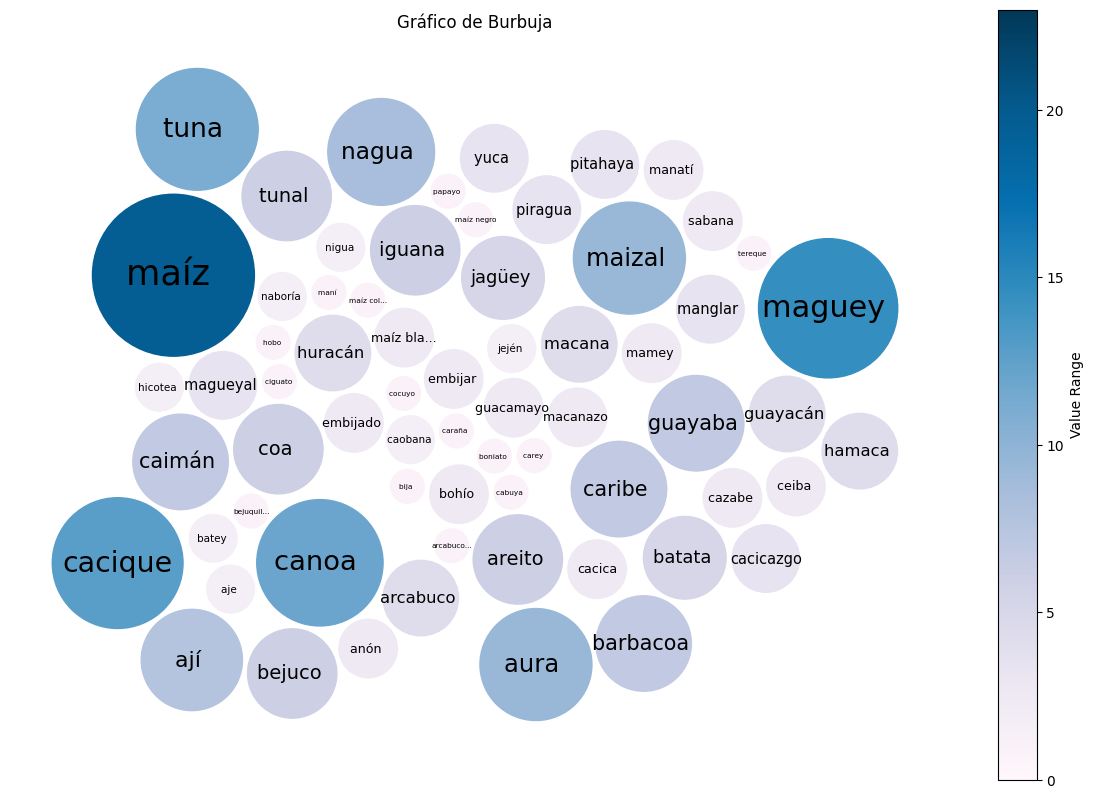

In [12]:
# Parámetros
path_excel = '29septantillanismos nueva españa(1).xlsx'
nombre_col_valores = 'hola'

Titulo = 'Gráfico de Burbuja'
color_map = cm.PuBu
text_size = 2.2
text_color = 'black'
legend = True
bubble_spacing = 0.2


palabras,valores = read_data(path_excel,nombre_col_valores,remove_last=True,remove_zeros=True)
data = [palabras,valores]

make_bubble_graph(data,title = Titulo,color_map = color_map ,text_size = text_size,text_color = text_color,legend = legend,bubble_spacing = bubble_spacing)
